### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import pickle
import copy
import gc

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
run = 1
run_str = "run" + str(run)

<IPython.core.display.Javascript object>

In [5]:
pot_target = 10.1e20  # Run1+Run3
lee_focus = 1

<IPython.core.display.Javascript object>

In [6]:
x_sce_magic = 1.03
pid_upper_clip = 300

<IPython.core.display.Javascript object>

In [7]:
max_trk_score = 0.4
min_cluster_frac = 0.25
min_shw_e = 75  # MeV
max_cosmic_impact = 15
min_topo_score = 0.15

<IPython.core.display.Javascript object>

In [8]:
retrain = False
train_run1 = {
    "run1": ["ccpi0", "elee_high", "elee_low", "ncpi0", "ccpi0train"],
    "run3": ["elee_high", "elee_low", "nu", "nue", "ncpi0", "ccpi0", "ccpi0train"],
}
train_run3 = {
    "run1": ["ccpi0", "elee_high", "elee_low", "ncpi0", "nue", "nu", "ccpi0train"],
    "run3": ["elee_high", "elee_low", "ncpi0", "ccpi0", "ccpi0train"],
}
plot_samples = ["nu", "nue", "on", "off", "dirt"]
train_samples = {"run1": train_run1, "run3": train_run3}
seed = 7
test_size = 0.25

<IPython.core.display.Javascript object>

### Load Samples

In [9]:
input_dir = "./input/05Dec/".format(run)
output_dir = "./output/run{}/".format(run)
model_dir = "./models/run{}/".format(run)

<IPython.core.display.Javascript object>

In [10]:
%%time
data_run1 = pickle.load(open(input_dir+"run1_slimmed.pckl".format(run), 'rb'))
data_run3 = pickle.load(open(input_dir+"run3_slimmed.pckl".format(run), 'rb'))
data_samples = {
    "run1": data_run1,
    "run3": data_run3,
}

CPU times: user 1.34 s, sys: 2.04 s, total: 3.37 s
Wall time: 3.39 s


<IPython.core.display.Javascript object>

In [11]:
sample_info = {}
for s in plot_samples:
    sample_info[s] = data_samples[run_str][s]

# Prepare training data set
sample_info["train"] = {}
daughter_df_list = []
train_names = []
num_entries = 0
for run_i in train_samples[run_str]:
    for sample_i in train_samples[run_str][run_i]:
        daughter_df_list.append(data_samples[run_i][sample_i]["daughters"])
        num_entries += data_samples[run_i][sample_i]["numentries"]
        train_names.append(run_i + "_" + sample_i)
sample_info["train"]["daughters"] = pd.concat(
    daughter_df_list, sort=False, copy=True, verify_integrity=True, keys=train_names
)
sample_info["train"]["daughters"].index.names = ["sample", "event", "daughter"]
sample_info["train"]["numentries"] = num_entries
print("Training set constructed with {} entries.".format(num_entries))

# Be friendly to your memory!
del data_run1
del data_run3
del data_samples
del daughter_df_list
gc.collect()

Training set constructed with 1890969 entries.


26

<IPython.core.display.Javascript object>

In [12]:
pot_scale = pot_target / sample_info["on"]["pot"]

<IPython.core.display.Javascript object>

### Explore Tree

In [13]:
fields = sample_info["nue"]["fields"]
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [14]:
trk_fields

['trk_score_v',
 'trk_bragg_p_v',
 'trk_bragg_mu_v',
 'trk_bragg_mip_v',
 'trk_pida_v',
 'trk_pid_chipr_v',
 'trk_pid_chipi_v',
 'trk_pid_chika_v',
 'trk_pid_chimu_v',
 'trk_bragg_p_u_v',
 'trk_bragg_mu_u_v',
 'trk_bragg_mip_u_v',
 'trk_pida_u_v',
 'trk_pid_chipr_u_v',
 'trk_pid_chipi_u_v',
 'trk_pid_chika_u_v',
 'trk_pid_chimu_u_v',
 'trk_bragg_p_v_v',
 'trk_bragg_mu_v_v',
 'trk_bragg_mip_v_v',
 'trk_pida_v_v',
 'trk_pid_chipr_v_v',
 'trk_pid_chipi_v_v',
 'trk_pid_chika_v_v',
 'trk_pid_chimu_v_v',
 'trk_pfp_id_v',
 'trk_dir_x_v',
 'trk_dir_y_v',
 'trk_dir_z_v',
 'trk_start_x_v',
 'trk_start_y_v',
 'trk_start_z_v',
 'trk_sce_start_x_v',
 'trk_sce_start_y_v',
 'trk_sce_start_z_v',
 'trk_end_x_v',
 'trk_end_y_v',
 'trk_end_z_v',
 'trk_sce_end_x_v',
 'trk_sce_end_y_v',
 'trk_sce_end_z_v',
 'trk_distance_v',
 'trk_theta_v',
 'trk_phi_v',
 'trk_len_v',
 'trk_mcs_muon_mom_v',
 'trk_energy_proton_v',
 'trk_energy_muon_v',
 'trk_calo_energy_u_v',
 'trk_calo_energy_v_v',
 'trk_calo_energy_y_v',

<IPython.core.display.Javascript object>

In [15]:
shr_fields

['shr_dedx_u_v',
 'shr_dedx_v_v',
 'shr_dedx_y_v',
 'shr_energy_u_v',
 'shr_energy_v_v',
 'shr_energy_y_v',
 'shr_pfp_id_v',
 'shr_start_x_v',
 'shr_start_y_v',
 'shr_start_z_v',
 'shr_start_U_v',
 'shr_start_V_v',
 'shr_px_v',
 'shr_py_v',
 'shr_pz_v',
 'shr_openangle_v',
 'shr_theta_v',
 'shr_phi_v',
 'shr_pitch_u_v',
 'shr_pitch_v_v',
 'shr_pitch_y_v',
 'shr_tkfit_nhits_v',
 'shr_tkfit_start_x_v',
 'shr_tkfit_start_y_v',
 'shr_tkfit_start_z_v',
 'shr_tkfit_start_U_v',
 'shr_tkfit_start_V_v',
 'shr_tkfit_theta_v',
 'shr_tkfit_phi_v',
 'shr_tkfit_pitch_u_v',
 'shr_tkfit_pitch_v_v',
 'shr_tkfit_pitch_y_v',
 'shr_tkfit_dedx_u_v',
 'shr_tkfit_dedx_v_v',
 'shr_tkfit_dedx_y_v',
 'shr_tkfit_gap10_dedx_u_v',
 'shr_tkfit_gap10_dedx_v_v',
 'shr_tkfit_gap10_dedx_y_v',
 'shr_tkfit_dedx_nhits_u_v',
 'shr_tkfit_dedx_nhits_v_v',
 'shr_tkfit_dedx_nhits_y_v',
 'shr_moliere_avg_v',
 'shr_moliere_rms_v',
 'shr_spacepoint_start_x_v',
 'shr_spacepoint_start_y_v',
 'shr_spacepoint_start_z_v',
 'shr_spacep

<IPython.core.display.Javascript object>

In [16]:
backracked_fields

['backtracked_pdg',
 'backtracked_e',
 'backtracked_purity',
 'backtracked_completeness',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_start_x',
 'backtracked_start_y',
 'backtracked_start_z',
 'backtracked_start_t',
 'backtracked_start_U',
 'backtracked_start_V',
 'backtracked_start_Y',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z',
 'backtracked_sce_start_U',
 'backtracked_sce_start_V',
 'backtracked_sce_start_Y']

<IPython.core.display.Javascript object>

In [17]:
other_fields

{'CosmicDirAll2DEnds',
 'CosmicDirAll2DOvlp',
 'CosmicDirAll3D',
 'CosmicIP',
 'CosmicIPAll2DEnds',
 'CosmicIPAll2DOvlp',
 'CosmicIPAll3D',
 'NeutrinoEnergy0',
 'NeutrinoEnergy1',
 'NeutrinoEnergy2',
 'SliceCaloEnergy0',
 'SliceCaloEnergy1',
 'SliceCaloEnergy2',
 'bdt_cosmic',
 'bdt_ext',
 'bdt_global',
 'bdt_nuNCpi0',
 'bdt_numuCC',
 'bdt_numuCCpi0',
 'best_cosmic_flashmatch_score',
 'best_obviouscosmic_flashmatch_score',
 'category',
 'ccnc',
 'contained_fraction',
 'contained_sps_ratio',
 'cosmic_flashmatch_score_v',
 'crthitpe',
 'crtveto',
 'dmc_boundary',
 'dshr_boundary',
 'dshr_x_boundary',
 'dshr_y_boundary',
 'dshr_z_boundary',
 'dtrk',
 'dtrk_boundary',
 'dtrk_x_boundary',
 'dtrk_y_boundary',
 'dtrk_z_boundary',
 'dvtx',
 'dvtx_boundary',
 'dvtx_x_boundary',
 'dvtx_y_boundary',
 'dvtx_z_boundary',
 'elec_c',
 'elec_e',
 'elec_p',
 'elec_vx',
 'elec_vy',
 'elec_vz',
 'endmuonmichel',
 'endmuonprocess',
 'evgamnhits',
 'evlepnhits',
 'evneunhits',
 'evnhits',
 'evnunhits',
 'e

<IPython.core.display.Javascript object>

In [18]:
# search through fields:
[f for f in fields if "truthFiducial" in f]

['truthFiducial']

<IPython.core.display.Javascript object>

In [51]:
sample_info["on"]["daughters"].keys()

Index(['run', 'sub', 'evt', 'topological_score', 'n_pfps', 'n_showers',
       'n_tracks', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y',
       'reco_nu_vtx_sce_z', 'reco_nu_vtx_x', 'reco_nu_vtx_y', 'reco_nu_vtx_z',
       'crtveto', 'crthitpe', 'slclustfrac', 'hits_ratio', 'CosmicIP',
       'contained_sps_ratio', 'contained_fraction', 'slpdg',
       'SliceCaloEnergy2', 'NeutrinoEnergy2', 'secondshower_Y_nhit',
       'secondshower_Y_vtxdist', 'ismerged', 'merge_bestdist', 'trk_score_v',
       'trk_distance_v', 'trk_theta_v', 'trk_phi_v', 'trk_len_v',
       'trk_llr_pid_score_v', 'trk_mcs_muon_mom_v', 'trk_calo_energy_y_v',
       'trk_sce_end_x_v', 'trk_sce_end_y_v', 'trk_sce_end_z_v',
       'trk_sce_start_x_v', 'trk_sce_start_y_v', 'trk_sce_start_z_v',
       'trk_start_x_v', 'trk_start_y_v', 'trk_start_z_v', 'shr_energy_y_v',
       'shr_energy_u_v', 'shr_energy_v_v', 'shr_tkfit_start_x_v',
       'shr_tkfit_start_y_v', 'shr_tkfit_start_z_v', 'shr_start_x_v',
       'shr_start_y_v'

<IPython.core.display.Javascript object>

### Add fields

In [20]:
%%time
# For all samples
for k, v in sample_info.items():
    print(k)
    grouper='event'
    if k=='train':
        grouper=['event','sample']
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
       helper.is_fid(
           *v["daughters"][
               ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
           ]
           .xs(0, level="daughter")
           .values.T
       ),
       v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby(grouper, sort=False).transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby(grouper, sort=False).transform(min)
    )
    # Add pfp at vtx:
    v["daughters"]["n_pfpvtx"] = v["daughters"].eval("trk_distance_v<3 & trk_distance_v>=0")
    v["daughters"]["n_pfpvtx"] = v["daughters"]['n_pfpvtx'].groupby(grouper, sort=False).transform(sum)
    v["daughters"]["n_pfp_farvtx"] = v["daughters"].eval("n_pfps-n_pfpvtx")
    # Add shower distance: 
    v["daughters"]["shr_dist_v"] = v["daughters"].eval('sqrt((shr_tkfit_start_x_v-reco_nu_vtx_x)**2+ (shr_tkfit_start_y_v-reco_nu_vtx_y)**2 + (shr_tkfit_start_z_v-reco_nu_vtx_z)**2)')
    # Add electron candidate check
    e_cand_str = 'pfnplanehits_U>0 & pfnplanehits_V>0 & pfnplanehits_Y>0 & trk_score_v<@max_trk_score & shr_tkfit_dedx_nhits_y_v>0 & pfp_generation_v==2'    
    data = v["daughters"][
               [
                   "pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y",
                   "trk_score_v",'shr_tkfit_dedx_nhits_y_v',
                   "shr_dist_v", 'pfp_generation_v', "shr_energy_y_v"
               ]
           ]
    electron_candidate = data.eval(e_cand_str)
    e_cand_maxe = data[electron_candidate]["shr_energy_y_v"].groupby(grouper, sort=False).transform(max) == data[electron_candidate]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    # Add weighted dedx:
    dedx_cols = ["shr_tkfit_dedx_u_v",
                   "shr_tkfit_dedx_v_v",
                   "shr_tkfit_dedx_y_v",
                   'shr_tkfit_nhits_v',
                   "shr_tkfit_dedx_nhits_u_v",
                   "shr_tkfit_dedx_nhits_v_v",
                   "shr_tkfit_dedx_nhits_y_v"]
    v["daughters"][dedx_cols]=v["daughters"][dedx_cols].clip(lower=0)
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/(shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    # Add weigthed pid chi mu/pr:
    pid_chi_cols = ["trk_pid_chipr_v",
    "trk_pid_chimu_v",
    "trk_pid_chipr_v_v",
    "trk_pid_chimu_v_v",
    "trk_pid_chipr_u_v",
    "trk_pid_chimu_u_v"]
    v["daughters"][pid_chi_cols]=v["daughters"][pid_chi_cols].clip(upper=pid_upper_clip)
    str_pidmu_weighted_mean='(trk_pid_chimu_v*pfnplanehits_Y+trk_pid_chimu_v_v*pfnplanehits_V+trk_pid_chimu_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chimu_wm_v']= v["daughters"].eval(str_pidmu_weighted_mean)
    str_pidpr_weighted_mean='(trk_pid_chipr_v*pfnplanehits_Y+trk_pid_chipr_v_v*pfnplanehits_V+trk_pid_chipr_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chipr_wm_v']= v["daughters"].eval(str_pidpr_weighted_mean)
    # Add the number of hits per length:
    v["daughters"]['hits_per_tklen_v']= v["daughters"].eval('pfnhits/trk_len_v')
    # Add the ratio between dedx at 0cm and 1cm:
    v["daughters"]['shr_tkfit_ratiogap_dedx_y_v']= v["daughters"].eval('shr_tkfit_dedx_y_v/shr_tkfit_gap10_dedx_y_v')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_subclusters_v']= v["daughters"].eval('pfpplanesubclusters_U+pfpplanesubclusters_V+pfpplanesubclusters_Y')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_tkfit_hitratio_v']= v["daughters"].eval('shr_tkfit_nhits_v/pfnhits')
    # Explore mcs muon momentum:
    v["daughters"]['trk_muon_hypothesis_ratio_v']= v["daughters"].eval('trk_mcs_muon_mom_v/trk_calo_energy_y_v')
    
    # Add muon veto:
    q_muon_select = "(trk_llr_pid_score_v>0.4 & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4)"
    v["daughters"]['mu_candidate']= v["daughters"].eval(q_muon_select)
    v["daughters"]["mu_candidate_event"] = v["daughters"]['mu_candidate'].groupby(grouper, sort=False).transform(max)

nu
nue
on
off
dirt
train
CPU times: user 18.6 s, sys: 2.18 s, total: 20.7 s
Wall time: 11.7 s


<IPython.core.display.Javascript object>

In [21]:
%%time
# For MC samples
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add distance between reco_sce and true vertex
        data = (
            v["daughters"][
                [
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z",
                    "true_nu_vtx_x",
                    "true_nu_vtx_y",
                    "true_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        data[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        
        v["daughters"]["true_vtx_distance"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Cross-check vtx distance
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "reco_nu_vtx_x",
                    "reco_nu_vtx_y",
                    "reco_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        v["daughters"]["true_vtx_distance_check"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Add the distance between the true neutrino vertex and the reconstructed shower start point
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "shr_tkfit_start_x_v",
                    "shr_tkfit_start_y_v",
                    "shr_tkfit_start_z_v",
                ]
            ]
            .values.T
        )
        v["daughters"]["true_shower_distance"] = np.linalg.norm(data[0:3] - data[3:6], axis=0)
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


CPU times: user 8.27 s, sys: 3.32 s, total: 11.6 s
Wall time: 6.66 s


<IPython.core.display.Javascript object>

In [22]:
%%time
# For MC samples, fields needed as training labels:
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add training labels and weights
        e_cand = v["daughters"]['e_candidate']
        e_good = v["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.8 & backtracked_completeness>0.8')
        e_cand_bad = v["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11')
        other_bad = v["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==0)')
        other_neutral = v["daughters"].eval('~e_candidate & (backtracked_pdg==22 | abs(backtracked_pdg)==211)')
        v["daughters"]['train_weight'] = v["daughters"].eval('weightSpline+leeweight*@lee_focus') # weight low energy electrons a bit higher
        v["daughters"]['train_weight'] = v["daughters"].eval('train_weight*(1+(75<shr_energy_y_v<400)*@lee_focus*e_candidate)') # weight low energy electrons a bit higher
        v["daughters"].loc[e_good, "train_weight"] *= 2 # can be tuned
        v["daughters"].loc[other_neutral, "train_weight"] = 0 # can be tuned
        
        v["daughters"]['train_label'] = 1
        v["daughters"].loc[e_cand_bad, "train_label"] = 0
        v["daughters"].loc[other_bad, "train_label"] = 0

CPU times: user 3.69 s, sys: 120 ms, total: 3.81 s
Wall time: 1.93 s


<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [23]:
query_preselect = "e_candidate & \
                   reco_fid_vol & \
                   slclustfrac>@min_cluster_frac & \
                   shr_energy_y_v>@min_shw_e & \
                   CosmicIP>@max_cosmic_impact & \
                   topological_score > @min_topo_score & \
                   ~(crtveto & crthitpe>100) & _closestNuCosmicDist>20"

<IPython.core.display.Javascript object>

In [24]:
%%time
# Passing rate pre-selection
for k, v in sample_info.items():
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"]=999
        
    grouper='event'
    if k=='train':
        grouper=['event','sample']
        v["daughters"]["_closestNuCosmicDist"].fillna(999, inplace=True)
    
    v["daughters"]["preselect"] = v["daughters"].eval(
        query_preselect
    )
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby(grouper, sort=False).transform(max)
    
    pass_rate = sum(v["daughters"].eval("e_candidate & preselect"))/v['numentries']
    print(k, "\t{:.2f}%".format(pass_rate * 100))
    
# Passing rate signal, weights applied!
pass_rate = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*weightSpline*nueccinc'))/sum(sample_info["nue"]["mc"]['weightSpline']*sample_info['nue']['mc']['nueccinc'] )
print("Nue signal passing the preselection \t{:.2f}%".format(pass_rate * 100))
nue_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(nue_pass,pot_target))
lee_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*leeweight*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass,pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & preselect)")) * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)")) / purity_denom,
    )
)

nu 	2.66%
nue 	37.52%
on 	0.59%
off 	0.09%
dirt 	0.09%
train 	11.57%
Nue signal passing the preselection 	47.55%
Nue Intrinsic signal passing: 630.373 per 1e+21 POT
Nue LEE signal passing: 33.032 per 1e+21 POT


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Purity MC: 2.6%
Data/MC-ratio: 0.94

CPU times: user 3.04 s, sys: 43.6 ms, total: 3.08 s
Wall time: 1.75 s


<IPython.core.display.Javascript object>

### Machine Learning Selection

In [25]:
col_train_electron = [
    # "trk_min_cos",
    "shr_dist_v",
    "shr_tkfit_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_moliere_avg_v",
    "shr_tkfit_hitratio_v",
    "shr_tkfit_gap10_dedx_y_v",
    "ismerged",
    "merge_bestdist",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "shr_subclusters_v"
    ##"train_weight",
    ##"train_label",
]
col_train_other = [
    "trk_score_v",
    "trk_distance_v",
    # "trk_len_v",
    "trk_llr_pid_score_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    # "hits_per_tklen_v",
    # "shr_tkfit_dedx_wm_v",
    # "shr_moliere_avg_v",
    "pfp_generation_v",
    # "shr_subclusters_v"
    ##"train_weight",
    ##"train_label",
]

col_train_event = [
    "n_showers",
    "n_pfp_farvtx",
    "hits_ratio",
    "contained_fraction",
    "score",
    # "score_other_max",
    "score_other_min",
    "score_other_mean",
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

#### Electron training

In [26]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_electron]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [27]:
# fit model no training data
if retrain:
    model_e = XGBClassifier(max_depth=5)
    model_e.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])
    dump(model_e, model_dir + "model_e.pckl")
else:
    model_e = load(model_dir + "model_e.pckl")

<IPython.core.display.Javascript object>

In [28]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.92      0.90      0.91     42449
non_electron       0.68      0.71      0.70     12251

    accuracy                           0.86     54700
   macro avg       0.80      0.81      0.80     54700
weighted avg       0.86      0.86      0.86     54700

Test accuracy: 86.15%
Train accuracy: 86.81%

1. feature ismerged (0.337506)
2. feature shr_dist_v (0.299932)
3. feature merge_bestdist (0.082579)
4. feature shr_tkfit_dedx_wm_v (0.068202)
5. feature shr_moliere_avg_v (0.044426)
6. feature shr_tkfit_dedx_y_v (0.043376)
7. feature shr_tkfit_gap10_dedx_y_v (0.037022)
8. feature shr_subclusters_v (0.028628)
9. feature secondshower_Y_nhit (0.025805)
10. feature shr_tkfit_hitratio_v (0.017328)
11. feature secondshower_Y_vtxdist (0.015198)


<IPython.core.display.Javascript object>

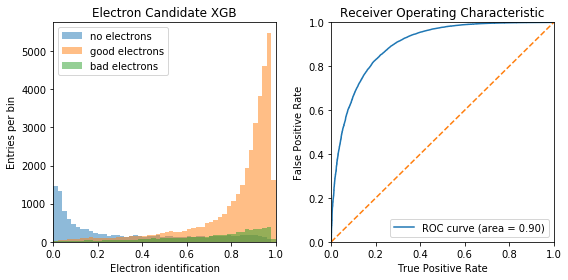

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_e.predict_proba(X_test).T[0]
tpr, fpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="no electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 0) & (y_test["train_weight"] > 1.99)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="good electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 0) & (y_test["train_weight"] < 1.99)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="bad electrons",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Electron Candidate XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "e_bdt_test.pdf")

#### Other daughters training

In [30]:
train_q = "preselect & ~e_candidate"
X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_other]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [31]:
# fit model on training data
if retrain:
    model_d = XGBClassifier(max_depth=6)
    model_d.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])
    dump(model_d, model_dir + "model_d.pckl")
else:
    model_d = load(model_dir + "model_d.pckl")

<IPython.core.display.Javascript object>

In [32]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.53      0.78      0.63     54447
muon, overlay, photon       0.84      0.63      0.72    100846

             accuracy                           0.68    155293
            macro avg       0.69      0.71      0.68    155293
         weighted avg       0.73      0.68      0.69    155293

Test accuracy: 68.39%
Train accuracy: 68.77%

1. feature trk_llr_pid_score_v (0.572806)
2. feature trk_distance_v (0.212864)
3. feature pfp_generation_v (0.068804)
4. feature pfp_trk_daughters_v (0.062613)
5. feature trk_score_v (0.058533)
6. feature pfp_shr_daughters_v (0.024380)


<IPython.core.display.Javascript object>

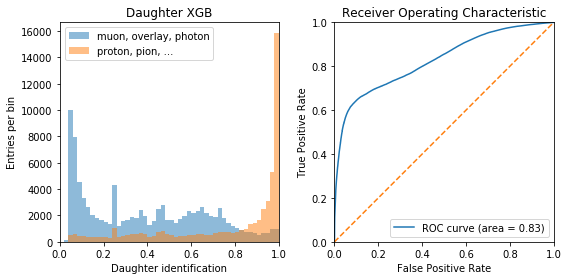

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_d.predict_proba(X_test).T[0]
tpr, fpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="muon, overlay, photon",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="proton, pion, ...",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Daughter identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Daughter XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "daughter_bdt_test.pdf")

#### Apply models on the samples!

In [34]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.5 µs


<IPython.core.display.Javascript object>

#### Train on the events

In [35]:
%%time
# First we need to add some columns:
for k, v in sample_info.items():    
    print(k)
    grouper = 'event'
    if k=='train':
        grouper = ['event', 'sample']
    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = 1
    
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = 1
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = 1
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .min()
        .values
    )

nu
nue
on
off
dirt
train
CPU times: user 6.38 s, sys: 509 ms, total: 6.89 s
Wall time: 3.62 s


<IPython.core.display.Javascript object>

In [36]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_event]
    Y = sample_info[k]["daughters"].query(train_q)[["nueccinc", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [37]:
# fit model on training data\
if retrain:
    model_event = XGBClassifier(max_depth=5)
    model_event.fit(X_train, y_train["nueccinc"], sample_weight=y_train["train_weight"])
    dump(model_event, model_dir + "model_event.pckl")
else:
    model_event = load(model_dir + "model_event.pckl")

<IPython.core.display.Javascript object>

In [38]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nueccinc"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nueccinc"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nueccinc"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.92      0.90      0.91     41799
background events       0.70      0.73      0.72     12901

         accuracy                           0.86     54700
        macro avg       0.81      0.82      0.81     54700
     weighted avg       0.87      0.86      0.86     54700

Test accuracy: 86.33%
Train accuracy: 87.04%

1. feature score (0.748535)
2. feature score_other_min (0.092661)
3. feature contained_fraction (0.046790)
4. feature hits_ratio (0.040303)
5. feature n_showers (0.034787)
6. feature score_other_mean (0.021792)
7. feature n_pfp_farvtx (0.015132)


<IPython.core.display.Javascript object>

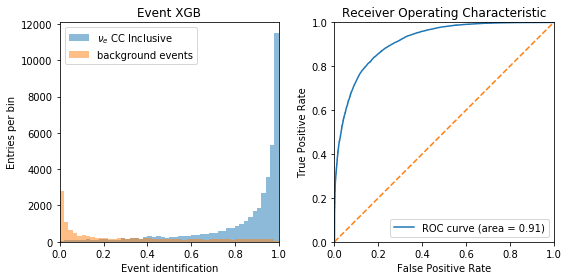

<IPython.core.display.Javascript object>

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_event.predict_proba(X_test).T[0]
fpr, tpr, _ = roc_curve(y_test["nueccinc"], y_pred)
roc_auc = auc(tpr, fpr)

ax[0].hist(
    y_pred[y_test["nueccinc"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nueccinc"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Event XGB")

ax[1].plot(tpr, fpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "event_bdt_test.pdf")

In [40]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    print(k)
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
nu
nue
on
off
dirt
train


<IPython.core.display.Javascript object>

In [41]:
# Get rid of this one annoying duplicated event
if run == 3:
    sample_info["on"]["daughters"].drop([14558, 15192], level="event", inplace=True)

<IPython.core.display.Javascript object>

In [42]:
query_select = "e_candidate & preselect & score_event>0.892"
# Passing rate selection
for k, v in sample_info.items():
    grouper = "event"
    if k == "train":
        grouper = ["event", "sample"]
    v["daughters"]["select"] = v["daughters"].eval(query_select)
    v["daughters"]["select"] = (
        v["daughters"]["select"].groupby(grouper, sort=False).transform(max)
    )

    pass_rate = sum(v["daughters"].eval("(e_candidate & select)")) / v["numentries"]
    print(k, "\t{:.4f}%".format(pass_rate * 100))

# Passing rate signal, weights applied!
pass_rate = sum(
    sample_info["nue"]["daughters"].eval("(e_candidate & select)*weightSpline*nueccinc")
) / sum(sample_info["nue"]["mc"]["weightSpline"] * sample_info["nue"]["mc"]["nueccinc"])
print("nue signal passing the selection \t{:.2f}%".format(pass_rate * 100))
nue_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print(
    "nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(
        nue_pass, pot_target
    )
)
lee_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*leeweight*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print("nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass, pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & select)"))
    * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
        / purity_denom,
    )
)

nu 	0.0688%
nue 	14.6740%
on 	0.0105%
off 	0.0021%
dirt 	0.0038%
train 	1.3003%
nue signal passing the selection 	18.80%
nue Intrinsic signal passing: 249.972 per 1e+21 POT
nue LEE signal passing: 15.675 per 1e+21 POT
Purity MC: 39.6%
Data/MC-ratio: 0.65



<IPython.core.display.Javascript object>

In [43]:
np.savetxt(
    output_dir + "events_run{}.txt".format(run),
    sample_info["on"]["daughters"].query("(e_candidate & select)")[
        ["run", "sub", "evt"]
    ],
    fmt="%u",
)
sample_info["on"]["daughters"].query("(e_candidate & select)")

,,run,sub,evt,topological_score,n_pfps,n_showers,n_tracks,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,reco_nu_vtx_x,reco_nu_vtx_y,reco_nu_vtx_z,crtveto,crthitpe,slclustfrac,hits_ratio,nu_flashmatch_score,selected,category,nslice,CosmicIP,n_tracks_contained,contained_sps_ratio,contained_fraction,slpdg,SliceCaloEnergy2,NeutrinoEnergy2,secondshower_Y_nhit,secondshower_Y_vtxdist,secondshower_Y_dot,secondshower_Y_dir,shrclusdir2,CosmicIPAll3D,CosmicDirAll3D,ismerged,merge_bestdot,merge_bestdist,trk_score_v,trk_distance_v,trk_theta_v,trk_phi_v,trk_len_v,trk_pid_chipr_v,trk_pid_chimu_v,trk_pid_chipr_v_v,trk_pid_chimu_v_v,trk_pid_chipr_u_v,trk_pid_chimu_u_v,trk_llr_pid_u_v,trk_llr_pid_v_v,trk_llr_pid_y_v,trk_llr_pid_v,trk_llr_pid_score_v,trk_mcs_muon_mom_v,trk_calo_energy_y_v,trk_sce_end_x_v,trk_sce_end_y_v,trk_sce_end_z_v,trk_sce_start_x_v,trk_sce_start_y_v,trk_sce_start_z_v,trk_start_x_v,trk_start_y_v,trk_start_z_v,shr_energy_y_v,shr_energy_u_v,shr_energy_v_v,shr_tkfit_start_x_v,shr_tkfit_start_y_v,shr_tkfit_start_z_v,shr_start_x_v,shr_start_y_v,shr_start_z_v,shr_tkfit_theta_v,shr_tkfit_phi_v,shr_phi_v,shr_theta_v,shr_tkfit_dedx_u_v,shr_tkfit_dedx_v_v,shr_tkfit_dedx_y_v,shr_tkfit_gap10_dedx_u_v,shr_tkfit_gap10_dedx_v_v,shr_tkfit_gap10_dedx_y_v,shr_tkfit_nhits_v,shr_tkfit_dedx_nhits_u_v,shr_tkfit_dedx_nhits_v_v,shr_tkfit_dedx_nhits_y_v,shr_moliere_avg_v,shr_moliere_rms_v,pfnplanehits_U,pfnplanehits_V,pfnplanehits_Y,pfpplanesubclusters_U,pfpplanesubclusters_V,pfpplanesubclusters_Y,pfpplanesubhitfracmax_U,pfpplanesubhitfracmax_V,pfpplanesubhitfracmax_Y,pfnhits,pfp_generation_v,pfp_trk_daughters_v,pfp_shr_daughters_v,trk_min_cos,reco_fid_vol,all_start_contained,all_end_contained,n_pfpvtx,n_pfp_farvtx,shr_dist_v,e_candidate,shr_tkfit_dedx_wm_v,trk_pid_chimu_wm_v,trk_pid_chipr_wm_v,hits_per_tklen_v,shr_tkfit_ratiogap_dedx_y_v,shr_subclusters_v,shr_tkfit_hitratio_v,trk_muon_hypothesis_ratio_v,mu_candidate,mu_candidate_event,_closestNuCosmicDist,preselect,score,score_other_max,score_other_mean,score_other_min,score_event,select
event,daughter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1604,0,5273,84,4249,0.152262,1,1,0,209.031281,-68.360710,828.972595,211.131378,-62.625164,828.606567,0,0.0,0.672222,1.000000,10.884195,1,0,1,29.519234,0,1.000000,1.000000,12,57.799789,240.803955,2,51.653168,0.511715,211.721375,3.549091e+02,29.519234,0.995068,0,0.000000e+00,1.000000e+06,0.115784,0.240358,1.698646,-0.207803,29.763741,300.000000,37.763912,229.633118,23.059381,300.000000,35.912811,75.461029,34.987000,55.997002,166.445038,0.655584,0.174603,1126.349976,238.528564,-77.258080,826.395081,209.048584,-68.426697,829.207275,211.147263,-62.684082,828.839050,192.643173,173.086395,126.387428,211.971832,-62.634655,828.633484,211.133392,-62.769466,828.899963,1.750824,-0.253856,-0.236548,1.677433,0.266586,6.488559,1.008765,3.337603e-01,6.488559e+00,-1.000000,27,2,4,1,3.463782,211.541855,84,65,93,1,1,1,0.0,0.0,0.0,242,2,0,0,1.000000,True,True,True,1.0,0.0,0.840939,True,3.928025,33.171817,281.099804,8.130698,-1.008765,3,0.111570,0.000155,False,False,999,True,0.909500,1.000000,1.000000,1.000000,0.929385,True
14226,0,5532,46,2304,0.996365,6,4,2,208.264450,25.326622,923.771179,210.674179,23.843607,921.993103,0,0.0,0.874616,0.984821,1.245698,0,0,1,68.415092,1,0.984431,0.825564,12,290.199951,1217.916382,3,12.272942,0.375054,338.962250,2.381314e+02,68.415092,-0.302429,1,-8.497082e-01,5.626354e-01,0.085650,0.315052,0.118102,-0.249439,102.799156,256.080872,20.032749,194.212402,24.812418,300.000000,36.261444,286.947998,267.592865,655.605469,1210.146362,0.947512,0.346222,866.759033,220.158951,45.452435,1009.901184,208.213989,25.081476,923.984802,210.624496,23.612204,922.201050,596.807617,519.255310,524.753113,210.630386,23.444105,921.926270,210.707001,23.659855,922.200012,0.109134,-0.032356,-0.571936,0.041181,5.252500,1.853980,1.507022,-1.000000e+00,1.838797e+00,1.356460,220,1,4,

<IPython.core.display.Javascript object>

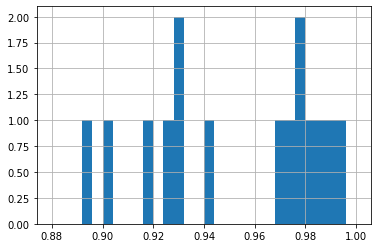

<IPython.core.display.Javascript object>

In [44]:
sample_info["on"]["daughters"].query("(e_candidate & select)")["score_event"].hist(
    range=(0.88, 1), bins=30
)

In [45]:
cols_to_pickle = [
    "run",
    "sub",
    "evt",
    "topological_score",
    "n_pfps",
    "n_showers",
    "n_tracks",
    "reco_nu_vtx_x",
    "reco_nu_vtx_y",
    "reco_nu_vtx_z",
    "reco_nu_vtx_sce_x",
    "reco_nu_vtx_sce_y",
    "reco_nu_vtx_sce_z",
    "crtveto",
    "crthitpe",
    "slclustfrac",
    "hits_ratio",
    "CosmicIP",
    "contained_sps_ratio",
    "contained_fraction",
    "slpdg",
    "SliceCaloEnergy2",
    "NeutrinoEnergy2",
    "trk_score_v",
    "trk_distance_v",
    "trk_theta_v",
    "trk_phi_v",
    "trk_len_v",
    "trk_llr_pid_score_v",
    "trk_mcs_muon_mom_v",
    "trk_calo_energy_y_v",
    "trk_sce_end_x_v",
    "trk_sce_end_y_v",
    "trk_sce_end_z_v",
    "trk_sce_start_x_v",
    "trk_sce_start_y_v",
    "trk_sce_start_z_v",
    "trk_start_x_v",
    "trk_start_y_v",
    "trk_start_z_v",
    "shr_energy_y_v",
    "shr_energy_u_v",
    "shr_energy_v_v",
    "shr_phi_v",
    "shr_theta_v",
    "shr_tkfit_start_x_v",
    "shr_tkfit_start_y_v",
    "shr_tkfit_start_z_v",
    "shr_start_x_v",
    "shr_start_y_v",
    "shr_start_z_v",
    "shr_tkfit_theta_v",
    "shr_tkfit_phi_v",
    "shr_tkfit_dedx_u_v",
    "shr_tkfit_dedx_v_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_tkfit_nhits_v",
    "shr_tkfit_dedx_nhits_y_v",
    "shr_moliere_avg_v",
    "shr_moliere_rms_v",
    "pfnplanehits_Y",
    "pfpplanesubclusters_Y",
    "pfpplanesubhitfracmax_Y",
    "pfnhits",
    "pfp_generation_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "true_nu_vtx_sce_x",
    "true_nu_vtx_sce_y",
    "true_nu_vtx_sce_z",
    "nu_e",
    "lep_e",
    "nu_pdg",
    "nelec",
    "npion",
    "npi0",
    "nproton",
    "nmuon",
    "theta",
    "ccnc",
    "interaction",
    "weightSpline",
    "leeweight",
    "nu_completeness_from_pfp",
    "nu_purity_from_pfp",
    "backtracked_pdg",
    "backtracked_e",
    "backtracked_completeness",
    "backtracked_purity",
    "backtracked_overlay_purity",
    "backtracked_px",
    "backtracked_py",
    "backtracked_pz",
    "backtracked_sce_start_x",
    "backtracked_sce_start_y",
    "backtracked_sce_start_z",
    "trk_min_cos",
    "nueccinc",
    "true_category",
    "reco_fid_vol",
    "all_start_contained",
    "all_end_contained",
    "n_pfpvtx",
    "n_pfp_farvtx",
    "shr_dist_v",
    "e_candidate",
    "shr_tkfit_dedx_wm_v",
    "hits_per_tklen_v",
    "shr_tkfit_ratiogap_dedx_y_v",
    "shr_subclusters_v",
    "shr_tkfit_hitratio_v",
    "trk_muon_hypothesis_ratio_v",
    "mu_candidate",
    "mu_candidate_event",
    "true_vtx_distance",
    "true_vtx_distance_check",
    "true_shower_distance",
    "_closestNuCosmicDist",
    "preselect",
    "score",
    "score_other_max",
    "score_other_mean",
    "score_other_min",
    "score_event",
    "select",
    "ismerged",
    "merge_bestdist",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
]

<IPython.core.display.Javascript object>

In [46]:
print([x for x in cols_to_pickle if cols_to_pickle.count(x) > 1])

[]


<IPython.core.display.Javascript object>

In [47]:
write_output_to_pickle = True
if write_output_to_pickle:
    for sample in list(sample_info.keys()):
        if sample in plot_samples:
            print(sample)
            columns_to_drop = set(sample_info[sample]["daughters"].keys()) - set(
                cols_to_pickle
            )
            sample_info[sample]["daughters"].drop(columns_to_drop, inplace=True, axis=1)
        else:
            del sample_info[sample]
    pickle_out = open(input_dir + "after_training_run{}.pckl".format(run), "wb")
    pickle.dump(sample_info, pickle_out)
    pickle_out.close()

nu
nue
on
off
dirt


<IPython.core.display.Javascript object>

### Plots

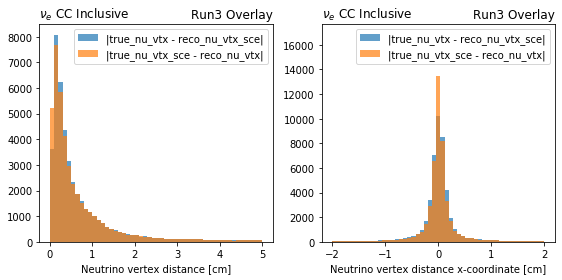

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")

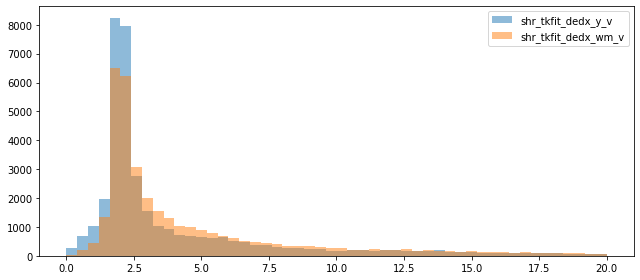

<IPython.core.display.Javascript object>

In [49]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 4))

data = sample_info["nue"]["daughters"].query("e_candidate & abs(backtracked_pdg==11)")[
    ["shr_tkfit_dedx_y_v", "shr_tkfit_dedx_wm_v"]
]

for col in data.columns:
    ax.hist(data[col], bins=50, range=(0, 20), label=col, alpha=0.5)
ax.legend()

fig.tight_layout()
fig.savefig(output_dir + "e_preselection_dedx.pdf")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


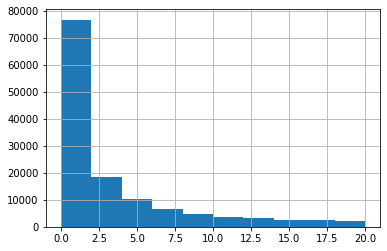

<IPython.core.display.Javascript object>

In [50]:
data = sample_info["nue"]["daughters"][
    [
        "shr_tkfit_start_x_v",
        "shr_tkfit_start_y_v",
        "shr_tkfit_start_z_v",
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
    ]
].values.T
sample_info["nue"]["daughters"]["shr_dist_v"] = np.linalg.norm(
    data[0:3] - data[3:6], axis=0
)


sample_info["nue"]["daughters"]["shr_dist_v"].hist(range=(0, 20))